In [1]:
import sys
sys.path.append("../src/")

import numpy as np

import matplotlib.pyplot as plt

from produce_dgd import (
    start_end_times,
    censoring
)

from mask import simulate_mask
from summary import data_summary

import scipy.stats as st 

from splitting import train_val_test_splitting, train_val_test_subsample

from dgd_data_generator import simulate_float_from_named_basis, simulate_dgd

%matplotlib inline

In [2]:
SEED = 42

In [3]:
# Rank.
r = 5
# Number of females.
N = 200
# Number of time points.
T = 340

# Generate continous latent screening profiles

In [4]:
# Sample times for first and last screening from distributions 
# fitted to the empirical screening data.
t_start, t_cens = start_end_times(N=N, T=T)

In [5]:
# Generate the continous latent profiles.
M = simulate_float_from_named_basis(
    basis_name='simple_peaks', 
    N=len(t_start), 
    T=T,
    K=r,
    domain=[1, 4], 
    random_state=SEED
)

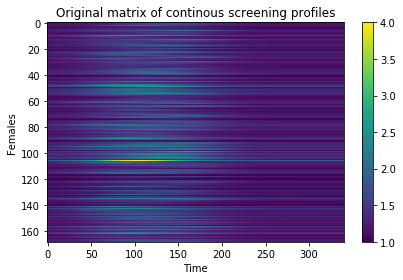

In [6]:
plt.figure()
plt.title("Original matrix of continous screening profiles")
plt.imshow(M, aspect="auto")
plt.ylabel("Females")
plt.xlabel("Time")
plt.colorbar()
plt.tight_layout()

In [7]:
np.save("../data/graph_learning/M.npy", M)

# Generate the graph

In [8]:
import networkx as nx

In [9]:
# A random graph Erdős-Rényi (binomial) graph. Chooses each of the possible 
# edges with probability p.
G = nx.erdos_renyi_graph(n=M.shape[0], p=0.05, seed=SEED, directed=False)

L = nx.normalized_laplacian_matrix(G)

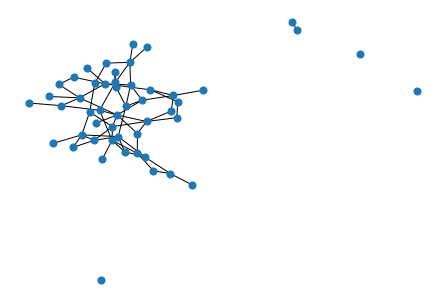

In [10]:
num_nodes = 50

plt.figure()
nx.draw(G.subgraph(np.arange(num_nodes)), node_size=num_nodes)

# Project the continous latent profiles onto the graph

$$
z_n^* = \arg \min_{z_n} \left \| m_n - z_n \right \|_2^2 + \lambda (z_n^\top L z_n) \Rightarrow z_n^* = (I + \lambda L)^{-1} m_n
$$

Here, $m_n$ is the continous latent profile, $z_n^*$ is the smoothened version of $m_n$ projected onto the graph represented by the graph Laplacian $L$. The signal smoothness is controlled by $\lambda$.

In [11]:
lmbda = 0.5

# The projected data which is smooth over the assumed graph. 
Z = np.asarray(np.matmul(np.linalg.inv(np.eye(L.shape[0]) + lmbda * L), M))
print(np.linalg.norm(Z.T @ L @ Z))

3023.1702243045584


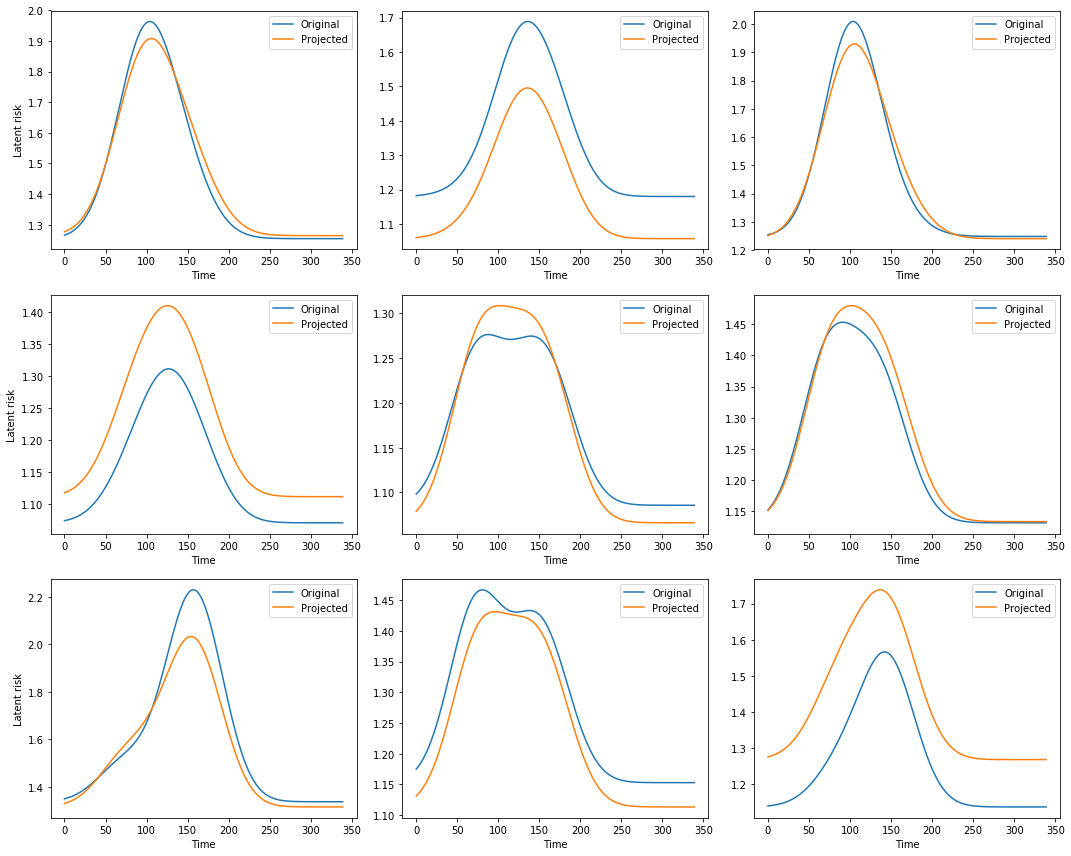

In [12]:
# Compare signals before and after projection and smoothing.
_, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
for i, axis in enumerate(axes.ravel()):

    axis.plot(M[i], label="Original")
    axis.plot(Z[i], label="Projected")
    axis.set_xlabel("Time")

    axis.legend()
    
    if i % 3 == 0:
        axis.set_ylabel("Latent risk")

plt.tight_layout()

# Discretize the continous signals

In [13]:
# Map the continous latent profiles into the four observed states.
D = simulate_dgd(
    Z, 
    domain_z=np.arange(1, 5),
    theta=2.5,
    random_state=SEED
)

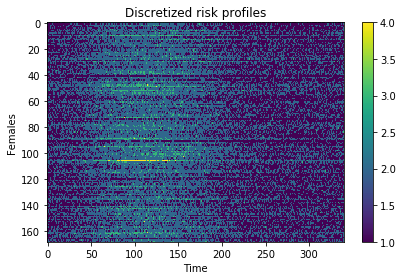

In [14]:
plt.figure()
plt.title("Discretized risk profiles")
plt.imshow(D, aspect="auto")
plt.ylabel("Females")
plt.xlabel("Time")
plt.colorbar()
plt.tight_layout()

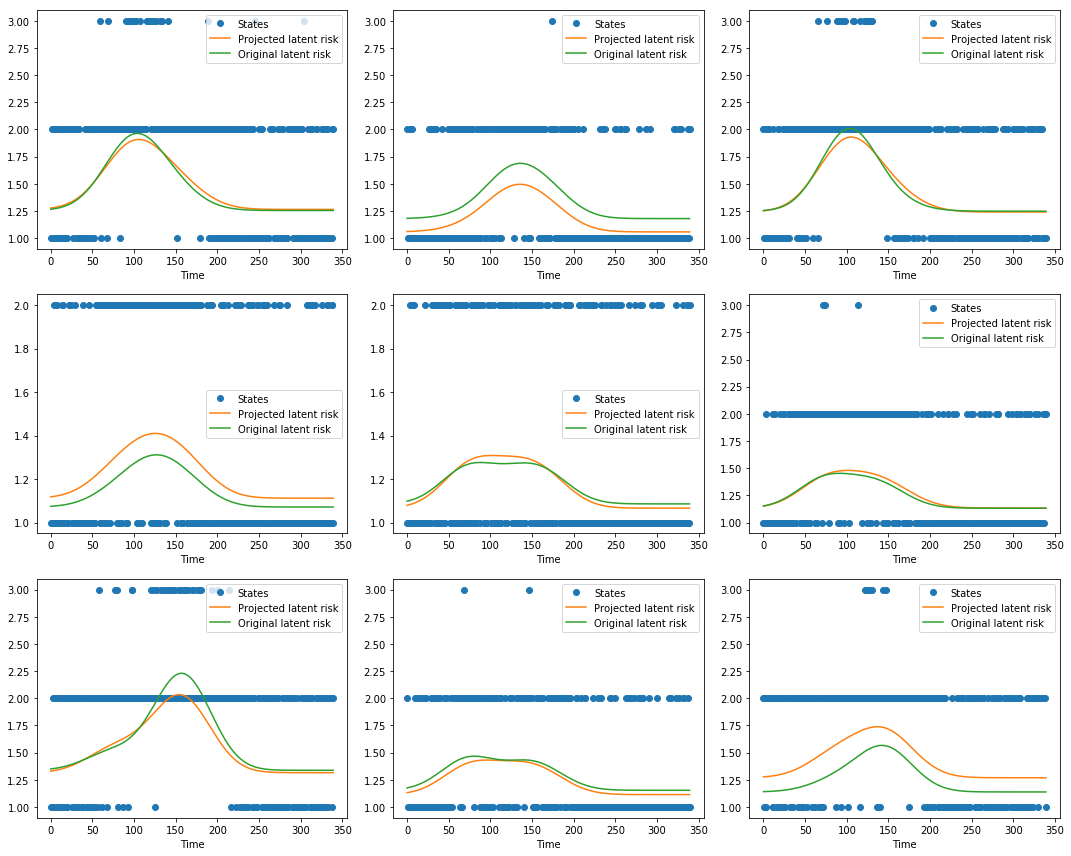

In [15]:
# Compare discrete and continous profiles.
_, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
for i, axis in enumerate(axes.ravel()):

    axis.plot(D[i], "o", label="States")
    axis.plot(Z[i], label="Projected latent risk")
    axis.plot(M[i], label="Original latent risk")
    axis.set_xlabel("Time")
    axis.legend()

plt.tight_layout()

# Simulate data scarcity

In [16]:
O = simulate_mask(
    D,
    screening_proba=np.array([0.05, 0.15, 0.4, 0.6, 0.2]),
    memory_length=10,
    level=3,
    random_state=SEED
)

Y = D * O
Y = censoring(t_start, t_cens, Y, missing=0)

valid_rows = np.count_nonzero(Y, axis=1) > 1

Z = Z[valid_rows]
Y = Y[valid_rows]

np.save("../data/graph_learning/Z.npy", Z)
np.save("../data/graph_learning/Y.npy", Y)

# Drop nodes that are no longer part of the data and recompute the Laplacian.
G.remove_nodes_from(np.arange(M.shape[0])[np.invert(valid_rows)])
L = nx.normalized_laplacian_matrix(G)

np.save("../data/graph_learning/A.npy", nx.to_numpy_array(G))

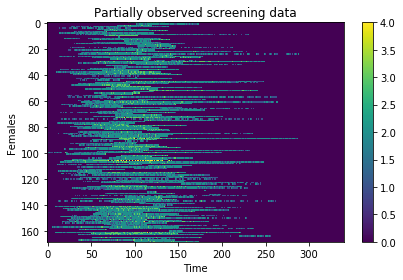

In [17]:
plt.figure()
plt.title("Partially observed screening data")
plt.imshow(Y, aspect="auto")
plt.ylabel("Females")
plt.xlabel("Time")
plt.colorbar()
plt.tight_layout()

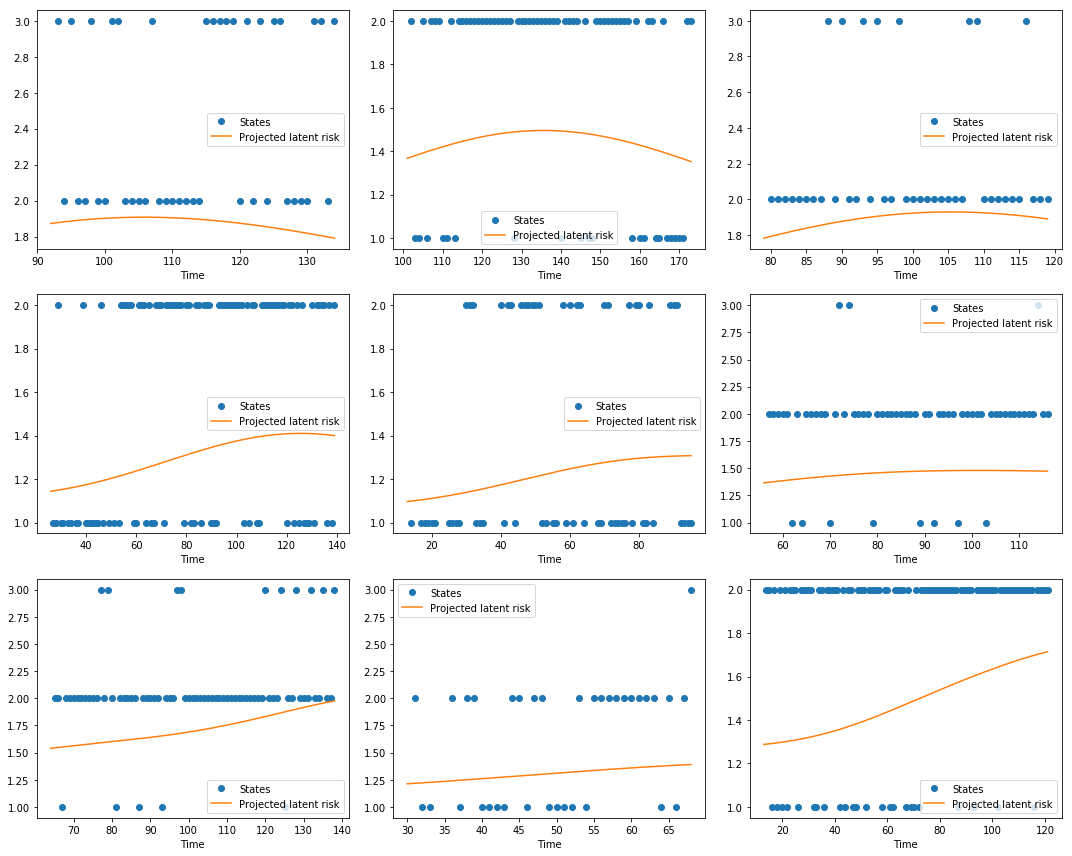

In [18]:
# Compare continous profiles to the partial discrete profiles.
_, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
for i, axis in enumerate(axes.ravel()):

    y = Y[i].copy()
    t_start = np.argmax(y != 0) - 1
    t_max = np.argmax(np.cumsum(y)) + 1
    y[y == 0] = np.nan

    z = np.ones_like(y) * np.nan
    z[t_start:t_max] = Z[i, t_start:t_max].copy()

    axis.plot(y, "o", label="States")
    axis.plot(z, label="Projected latent risk")
    axis.set_xlabel("Time")

    axis.legend()

plt.tight_layout()